In [1]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt

# Overview
- With physics informed neural networks we can 
    1. Solve a PDE
    2. If there are additional (noisy) data we can also learn the underlying parameters of the PDE.  In mathematical finance this procedure is called 'calibration'.
- In this notebook we will just look at the solution of a pde using neural networks.


# Physics-Informed Neural Network (PINN) for the damped harmonic oscillator

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above).

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this [blog post](https://beltoforion.de/en/harmonic_oscillator/).


#### Solving the PDE with Neural networks

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The NN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

#### Notes

- The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.
- The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.
- The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.
- [Reference implementation](https://github.com/benmoseley/harmonic-oscillator-pinn-workshop).

In [3]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden, n_layers):
        super().__init__()
        layers = []
        activation = nn.Tanh
        # Input layer
        layers.append(nn.Linear(n_input, n_hidden))
        layers.append(activation())
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_hidden, n_hidden))
            layers.append(activation())
        layers.append(nn.Linear(n_hidden, n_output))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)


def analytical_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

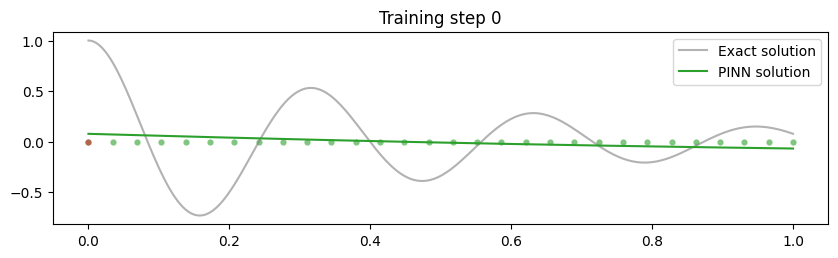

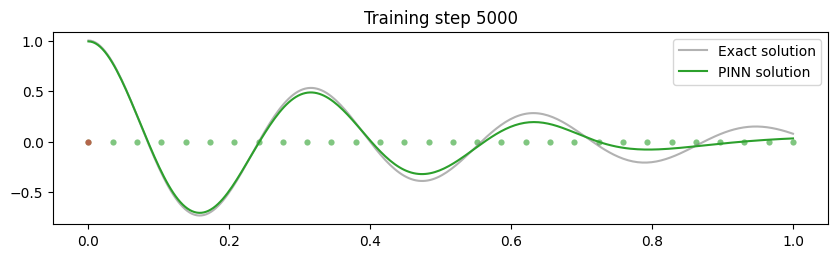

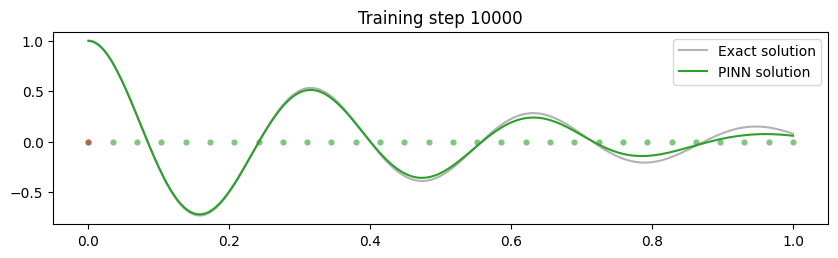

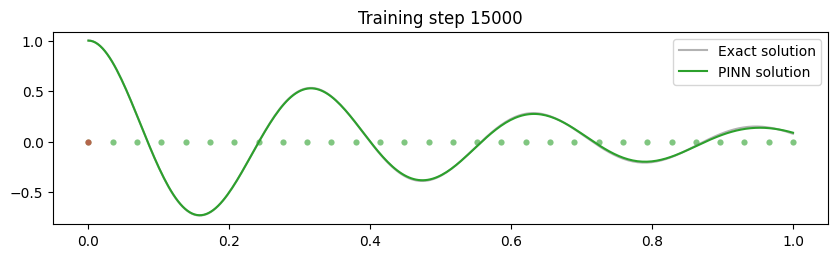

In [4]:
torch.manual_seed(123)
# Set model parameters
d, w0 = 2, 20
mu, k = 2*d, w0**2
lambda_1, lambda_2 = 1e-1, 1e-4

t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = analytical_solution(d, w0, t_test)

net  = Net(1,1,32,3)
# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)
# define training points over the entire domain, for the physics loss
t_domain = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

optimiser = torch.optim.Adam(net.parameters(),lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()
    # compute boundary loss
    u = net(t_boundary)
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss_0 = (torch.squeeze(u) - 1)**2
    loss_1 = (torch.squeeze(dudt) - 0)**2

    # compute domain loss
    u = net(t_domain)
    dudt = torch.autograd.grad(u, t_domain, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_domain, torch.ones_like(dudt), create_graph=True)[0]
    loss_2 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    loss = loss_0 + lambda_1 * loss_1 + lambda_2 * loss_2

    # backpropagate joint loss, take optimiser step
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 5000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = net(t_test).detach()
        plt.figure(figsize=(10,2.5))
        plt.scatter(t_domain.detach()[:,0],
                    torch.zeros_like(t_domain)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

### Warning: extrapolation is still like any neural network

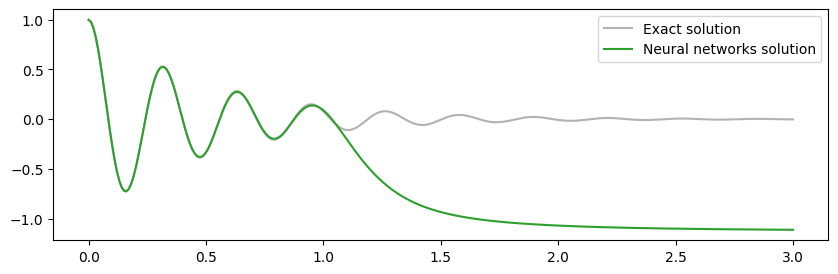

In [5]:

t_test = torch.linspace(0,3,300).view(-1,1)
u_exact = analytical_solution(d, w0, t_test)
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(t_test, u_exact, label="Exact solution", color="tab:grey", alpha=0.6)
ax.plot(t_test, net(t_test).detach(),  label="Neural networks solution", color="tab:green")
ax.legend()

# Todo: Physics-Informed Neural Network (PINN) for the 1D Heat Equation

We solve the **heat equation** on the domain $ x \in [0, 1] ,  t \in [0, 1]$:

$$
\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}, 
\quad x \in [0,1], \; t \in [0,1].
$$

**Boundary and initial conditions:**

$$
u(0, t) = u(1, t) = 0, 
\quad 
u(x, 0) = \sin(\pi x).
$$

**Analytical solution:**
$$ u(x, t) = e^{-\pi^2 t} \sin(\pi x) $$